# Deep Dreams (with Torch)

(this is a torch translated version of [this](https://github.com/google/deepdream/blob/master/dream.ipynb))

This notebook demonstrates how to use [Torch](http://torch.ch/) neural network framework to produce "dream" visuals shown in the [Google Research blog post](http://googleresearch.blogspot.ch/2015/06/inceptionism-going-deeper-into-neural.html).

It'll be interesting to see what imagery people are able to generate using the described technique. If you post images to Google+, Facebook, or Twitter, be sure to tag them with **#deepdream** so other researchers can check them out too.

##Dependencies
This notebook is designed to have as few dependencies as possible:
* [loadcaffe](https://github.com/szagoruyko/loadcaffe) package for Torch to load caffe models
* [cudnn](https://github.com/soumith/cudnn.torch) for speed

To install them after you install Torch do
```
luarocks install loadcaffe
luarocks install cudnn
```

# Imports and basic notebook setup

In [1]:
require 'image'
require 'loadcaffe'

cuda = true
torch.setdefaulttensortype('torch.FloatTensor')

Normalization = {mean = 118.380948/255, std = 61.896913/255}

## Loading DNN model
In this notebook we are going to use a [VGG-19](https://gist.github.com/ksimonyan/3785162f95cd2d5fee77#file-readme-md) model trained on [ImageNet](http://www.image-net.org/) dataset.
Feel free to experiment with other models from Caffe [Model Zoo](https://github.com/BVLC/caffe/wiki/Model-Zoo). One particularly interesting [model](http://places.csail.mit.edu/downloadCNN.html) was trained in [MIT Places](http://places.csail.mit.edu/) dataset. It produced many visuals from the [original blog post](http://googleresearch.blogspot.ch/2015/06/inceptionism-going-deeper-into-neural.html).

In [2]:
-- VGG-19
model_path = '/opt/caffe/scripts/models/3785162f95cd2d5fee77/'
proto = model_path..'VGG_ILSVRC_19_layers_deploy.prototxt'
caffemodel = model_path..'VGG_ILSVRC_19_layers.caffemodel'

-- VGG-16
--model_path = '/opt/caffe/scripts/models/211839e770f7b538e2d8/'
--proto = model_path..'VGG_ILSVRC_16_layers_deploy.prototxt'
--caffemodel = model_path..'VGG_ILSVRC_16_layers.caffemodel'

-- we can you different backends here, e.g. nn, cudnn, or cuda-convnet2
-- to install them in Torch do "luarocks install cudnn" or "luarocks install ccn2"
net = loadcaffe.load(proto, caffemodel, 'cudnn')

print(tostring(net))

Successfully loaded /opt/caffe/scripts/models/3785162f95cd2d5fee77/VGG_ILSVRC_19_layers.caffemodel


conv1_1: 64 3 3 3
conv1_2: 64 64 3 3


conv2_1: 128 64 3 3


conv2_2: 128 128 3 3


conv3_1: 256 128 3 3


conv3_2: 256 256 3 3


conv3_3: 256 256 3 3


conv3_4: 256 256 3 3


conv4_1: 512 256 3 3


conv4_2: 512 512 3 3


conv4_3: 512 512 3 3


conv4_4: 512 512 3 3


conv5_1: 512 512 3 3


conv5_2: 512 512 3 3


conv5_3: 512 512 3 3


conv5_4: 512 512 3 3


fc6: 1 1 25088 4096


fc7: 1 1 4096 4096


fc8: 1 1 4096 1000


nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> (9) -> (10) -> (11) -> (12) -> (13) -> (14) -> (15) -> (16) -> (17) -> (18) -> (19) -> (20) -> (21) -> (22) -> (23) -> (24) -> (25) -> (26) -> (27) -> (28) -> (29) -> (30) -> (31) -> (32) -> (33) -> (34) -> (35) -> (36) -> (37) -> (38) -> (39) -> (40) -> (41) -> (42) -> (43) -> (44) -> (45) -> (46) -> output]
  (1): cudnn.SpatialConvolution(3 -> 64, 3x3, 1,1, 1,1)
  (2): cudnn.ReLU
  (3): cudnn.SpatialConvolution(64 -> 64, 3x3, 1,1, 1,1)
  (4): cudnn.ReLU
  (5): cudnn.SpatialMaxPooling
  (6): cudnn.SpatialConvolution(64 -> 128, 3x3, 1,1, 1,1)
  (7): cudnn.ReLU
  (8): cudnn.SpatialConvolution(128 -> 128, 3x3, 1,1, 1,1)
  (9): cudnn.ReLU
  (10): cudnn.SpatialMaxPooling
  (11): cudnn.SpatialConvolution(128 -> 256, 3x3, 1,1, 1,1)
  (12): cudnn.ReLU
  (13): cudnn.SpatialConvolution(256 -> 256, 3x3, 1,1, 1,1)
  (14): cudnn.ReLU
  (15): cudnn.SpatialConvolution(256 -> 256, 3x3, 1,1, 1,1)
  (16): cudnn.ReLU
  (

# Producing dreams

Making the "dream" images is very simple. Essentially it is just a gradient ascent process that tries to maximize the L2 norm of activations of a particular DNN layer. Here are a few simple tricks that we found useful for getting good images:
* offset image by a random jitter
* normalize the magnitude of gradient ascent steps
* apply ascent across multiple scales (octaves)

First we implement a basic gradient ascent step function, applying the first two tricks:

In [3]:
function make_step(net, img, end_layer,clip,step_size, jitter)
    local step_size = step_size or 0.01
    local jitter = jitter or 32
    local layer = layer or 15
    local clip = clip
    if clip == nil then clip = true end

    local ox = 0--2*jitter - math.random(jitter)
    local oy = 0--2*jitter - math.random(jitter)
    img = image.translate(img,ox,oy) -- apply jitter shift
    local cimg = cuda and img:cuda() or img
    local dst = net:forward(cimg)
    local g = net:backward(cimg,dst):float():squeeze()
    -- apply normalized ascent step to the input image
    img:add(g:mul(step_size/torch.abs(g):mean()))


    img = image.translate(img,-ox,-oy) -- apply jitter shift
    if clip then
        bias = Normalization.mean/Normalization.std
        img:clamp(-bias,1/Normalization.std-bias)
    end
    return img
end

Next we implement an ascent through different scales. We call these scales "octaves".

In [4]:
function deepdream(net, base_img, iter_n, octave_n, octave_scale, end_layer, clip, visualize)

    local function reduceNet(full_net,end_layer)
        local net = nn.Sequential()
        for l=1,end_layer do
            net:add(full_net:get(l))
        end
        return net
    end
    
    local iter_n = iter_n or 10
    local octave_n = octave_n or 4
    local octave_scale = octave_scale or 1.4
    local end_layer = end_layer or 20
    local net = reduceNet(net, end_layer)
    local clip = clip
    if clip == nil then clip = true end
    -- prepare base images for all octaves
    local octaves = {}
    octaves[octave_n] = torch.add(base_img, -Normalization.mean):div(Normalization.std)
    local _,h,w = unpack(base_img:size():totable())

    for i=octave_n-1,1,-1 do
        octaves[i] = image.scale(octaves[i+1], math.ceil((1/octave_scale)*w), math.ceil((1/octave_scale)*h),'simple')
    end


    local detail
    local src

    for octave, octave_base in pairs(octaves) do
        src = octave_base
        local _,h1,w1 = unpack(src:size():totable())
        if octave > 1 then
            -- upscale details from the previous octave
            detail = image.scale(detail, w1, h1,'simple')
            src:add(detail)
        end
        for i=1,iter_n do
            src = make_step(net, src, end_layer, clip)
            if visualize then
                -- visualization
                vis = torch.mul(src, Normalization.std):add(Normalization.mean)

                if not clip then -- adjust image contrast if clipping is disabled
                    vis = vis:mul(1/vis:max())
                end

                image.display(vis)
            end
        end
        -- extract details produced on the current octave
        detail = src-octave_base
        
        -- uncomment this to only show the resulting image
        --itorch.image(src:clone():mul(Normalization.std):add(Normalization.mean))
    end
    collectgarbage()
    -- returning the resulting image
    src:mul(Normalization.std):add(Normalization.mean)
    return src
end

Now we are ready to let the neural network to reveal its dreams! Let's take a cloud image as a starting point:

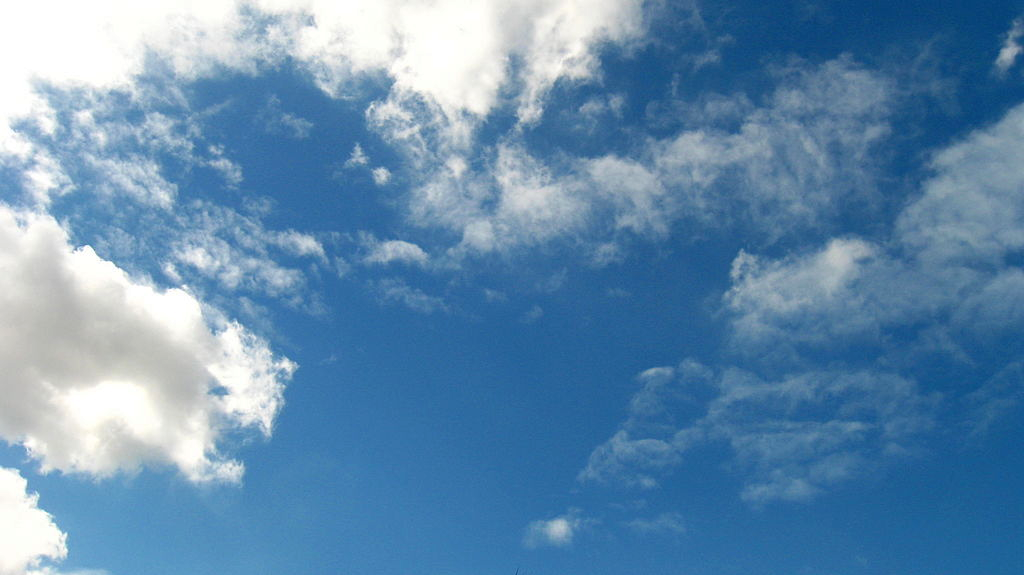

In [5]:
img = image.load'./sky1024px.jpg'
itorch.image(img)

Running the next code cell starts the detail generation process. You may see how new patterns start to form, iteration by iteration, octave by octave.

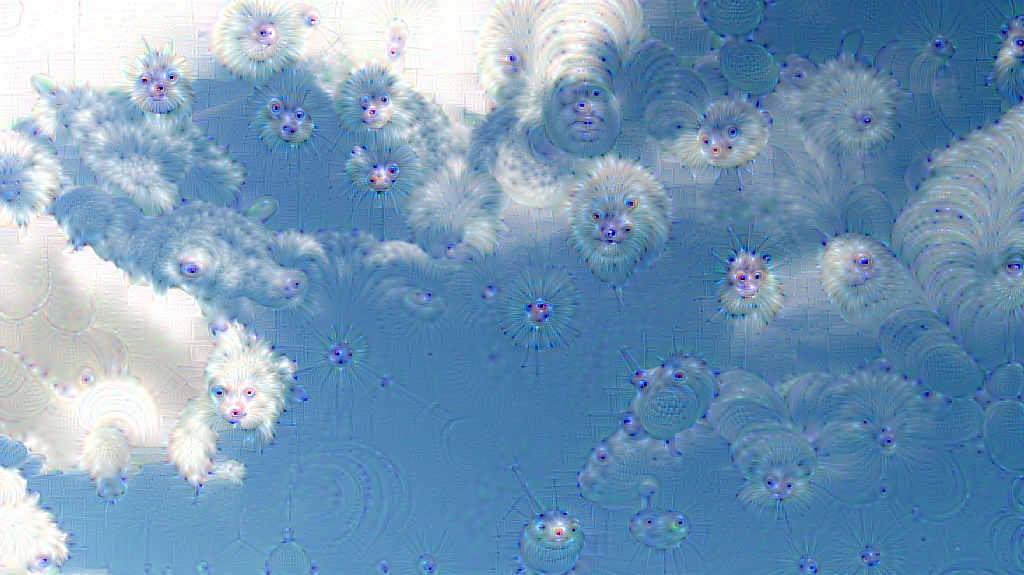

In [6]:
itorch.image(deepdream(net,img,10,4,1.4,30))

The complexity of the details generated depends on which layer's activations we try to maximize. Higher layers produce complex features, while lower ones enhance edges and textures, giving the image an impressionist feeling:

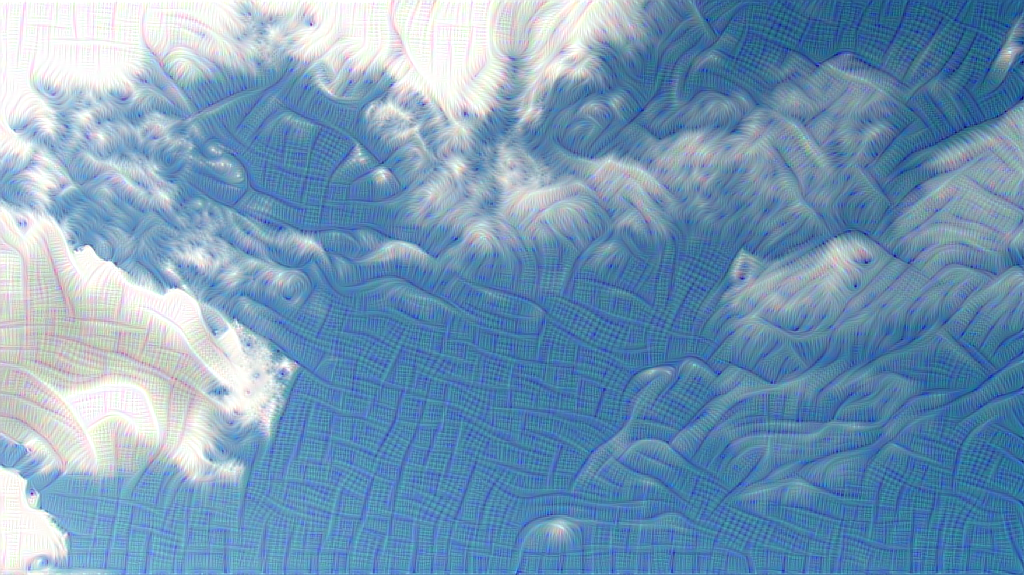

In [7]:
-- this would compute a dream every 3 layers of a net
--[[
for layer=4,30,3 do
    print(layer..': '..tostring(net:get(layer)))
    itorch.image(deepdream(net,img,10,4,1.4,layer))
end
]]--
itorch.image(deepdream(net,img,10,4,1.4,20))


We encourage readers to experiment with layer selection to see how it affects the results. Execute the next code cell to see the list of different layers. You can modify the make_step function to make it follow some different objective, say to select a subset of activations to maximize, or to maximize multiple layers at once. There is a huge design space to explore!

What if we feed the deepdream function its own output, after applying a little zoom to it? It turns out that this leads to an endless stream of impressions of the things that the network saw during training. Some patterns fire more often than others, suggestive of basins of attraction.
We will start the process from the same sky image as above, but after some iteration the original image becomes irrelevant; even random noise can be used as the starting point.

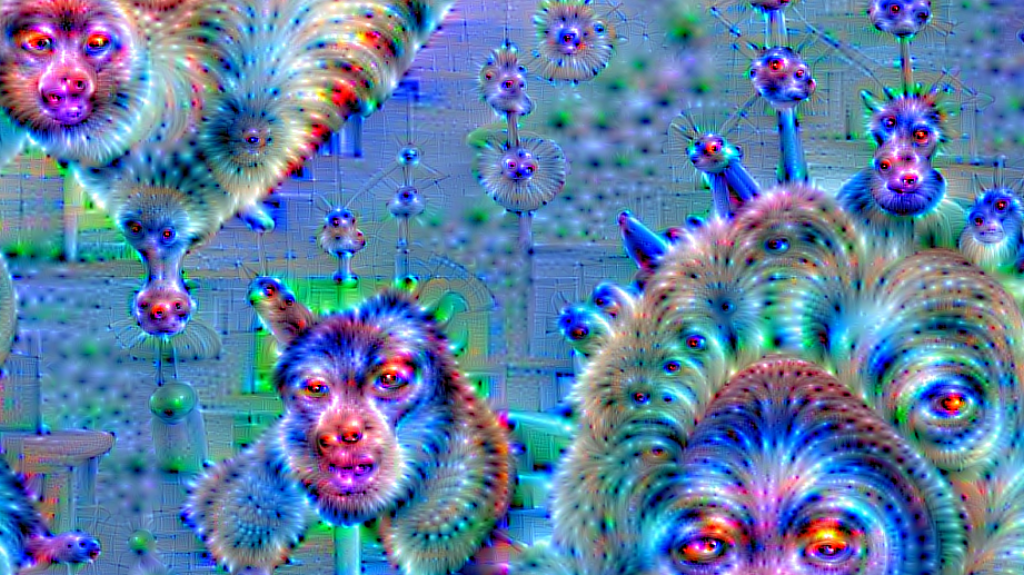

In [8]:
s = 0.95
frame = img:clone()
local _,h,w = unpack(img:size():totable())
for i=1,20 do
    frame = deepdream(net,frame,10,4,1.4,30)
    --itorch.image(frame)
    frame = image.crop(frame, w*(1-s),h*(1-s),w*s,h*s)
    frame = image.scale(frame, w,h)
end
itorch.image(frame)